# Introduction
<span style="font-size:12pt; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', sans-serif; color:#FF80C0; font-weight:bold; "> We have a collection of flower pictures and we want to classify them
the pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. </span>

In [1]:
import os
for dirname, _, filenames in os.walk('/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/.DS_Store
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/14167534527_781ceb1b7a_n.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/34718882165_68cdc9def9_n.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/5512287917_9f5d3f0f98_n.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/476857510_d2b30175de_n.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/521762040_f26f2e08dd.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/33837577463_1ae52a3726_n.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/34638378196_216d5bbc2e_n.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/7320089276_87b544e341.jpg
/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers/daisy/8008

In [2]:
# Libraries we need to import
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as f
import torch.optim as optim
from torchvision import transforms, datasets
from torchinfo import summary
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

import os
import random
import warnings
import cv2
warnings.filterwarnings('ignore')

from keras import backend as K

In [3]:
# Check device, use GPU if available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# Load data
transforms = transforms.Compose([
    transforms.Resize(256),    
    transforms.CenterCrop(224),  
    transforms.ToTensor()          
])

path = "/Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers"
 
data = datasets.ImageFolder(path, transform=transforms)

In [5]:
data

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /Users/gulei/Desktop/course/ama564 dl/group project/564project/flowers
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [6]:
# Define hyperparameters
image_size = (224, 224)
batch_size = 32

# Split data
shuffled_indices = np.random.permutation(len(data))
train_idx = shuffled_indices[:int(0.8*len(data))]
val_idx = shuffled_indices[int(0.8*len(data)):]

train_data = DataLoader(data, batch_size = batch_size, sampler = SubsetRandomSampler(train_idx))
test_data = DataLoader(data, batch_size = batch_size, sampler = SubsetRandomSampler(val_idx))

In [7]:
print(train_idx.size,val_idx.size)

3453 864


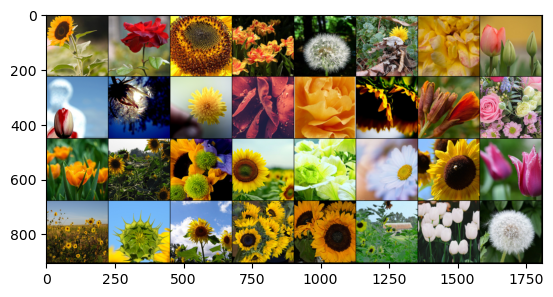

In [8]:
# Show pictures
for i, data in enumerate(train_data):
    images, labels = data
    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
    break

# Model

In [9]:
# Load pretrained weight
model_urls = {
    "squeezenet1_0": "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth",
    "squeezenet1_1": "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth",
}

In [10]:
class Fire(nn.Module):
    def __init__(self, in_channels:int, squeeze_channels:int, expand1x1_channels:int, expand3x3_channels:int) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand1x1_channels,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand3x3_channels,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        e1 = self.expand1x1_activation(self.expand1x1(x))
        e2 = self.expand3x3_activation(self.expand3x3(x))
        out = torch.cat([e1, e2], 1)
        return out


class SqueezeNet(nn.Module):
    def __init__(self, version='1_0', num_classes=1000): 
        super().__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )

        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )

        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        out = torch.flatten(x, 1)
        return out

def _squeezenet(version: str, pretrained: bool, progress: bool, **kwargs) -> SqueezeNet:
        model = SqueezeNet(version, **kwargs)
        if pretrained:
            arch = "squeezenet" + version
            state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
            model.load_state_dict(state_dict)
        return model    
    

def squeezenet1_0(pretrained: bool = False, progress: bool = True, **kwargs) -> SqueezeNet:
    return _squeezenet("1_0", pretrained, progress, **kwargs)


def squeezenet1_1(pretrained: bool = False, progress: bool = True, **kwargs):
    return _squeezenet("1_1", pretrained, progress, **kwargs)
    

In [11]:
# initialization
model = squeezenet1_0(pretrained=True)
model.classifier[1] = nn.Conv2d(in_channels=512, out_channels=5, kernel_size=(1, 1), stride=(1, 1))

y = model(torch.randn(1, 3, 224, 224))
print(y.size())
summary(model, (1, 3, 224, 224))

torch.Size([1, 5])


Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [1, 5]                    --
├─Sequential: 1-1                        [1, 512, 13, 13]          --
│    └─Conv2d: 2-1                       [1, 96, 109, 109]         14,208
│    └─ReLU: 2-2                         [1, 96, 109, 109]         --
│    └─MaxPool2d: 2-3                    [1, 96, 54, 54]           --
│    └─Fire: 2-4                         [1, 128, 54, 54]          --
│    │    └─Conv2d: 3-1                  [1, 16, 54, 54]           1,552
│    │    └─ReLU: 3-2                    [1, 16, 54, 54]           --
│    │    └─Conv2d: 3-3                  [1, 64, 54, 54]           1,088
│    │    └─ReLU: 3-4                    [1, 64, 54, 54]           --
│    │    └─Conv2d: 3-5                  [1, 64, 54, 54]           9,280
│    │    └─ReLU: 3-6                    [1, 64, 54, 54]           --
│    └─Fire: 2-5                         [1, 128, 54, 54]          --
│ 

In [12]:
lr = 1e-3
epochs = 50

# define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer1 = SummaryWriter('./runs/loss')
writer2 = SummaryWriter('./runs/acc')

In [14]:
def train(epoch):
    model.train()
    train_loss = 0
    gt_labels = []
    pred_labels = []

    for data, label in train_data:
        optimizer.zero_grad()
        output = model(data)
        preds = torch.argmax(output, 1)
        gt_labels.append(label.cpu().data.numpy())
        pred_labels.append(preds.cpu().data.numpy())
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(train_data.dataset)
    writer1.add_scalar('loss', train_loss, epoch)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    train_acc = np.sum(gt_labels ==pred_labels)/len(pred_labels)
    writer2.add_scalar('acc', train_acc, epoch)
    print('Epoch: {} \tTraining Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, train_loss, train_acc))
    return train_loss,train_acc

In [15]:
def val(epoch):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []

    with torch.no_grad():
        for data, label in test_data:
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)

    val_loss = val_loss /len(test_data.dataset)
    writer1.add_scalar('loss', val_loss, epoch)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    test_acc = np.sum(gt_labels ==pred_labels)/len(pred_labels)
    writer2.add_scalar('acc', test_acc, epoch)
    print('         \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(val_loss, test_acc))
    return val_loss,test_acc

In [17]:
train_losses = []
train_acces = []
eval_losses = []
eval_acces = []

for epoch in range(1, epochs+1):
    train_loss,train_acc = train(epoch)
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    val_loss,test_acc = val(epoch)
    eval_losses.append(val_loss)
    eval_acces.append(test_acc)

Epoch: 1 	Training Loss: 0.713120, Accuracy: 0.649290
         	Validation Loss: 0.176221, Accuracy: 0.668981
Epoch: 2 	Training Loss: 0.686931, Accuracy: 0.661743
         	Validation Loss: 0.186443, Accuracy: 0.693287
Epoch: 3 	Training Loss: 0.638979, Accuracy: 0.688097
         	Validation Loss: 0.144180, Accuracy: 0.746528
Epoch: 4 	Training Loss: 0.598457, Accuracy: 0.722270
         	Validation Loss: 0.150611, Accuracy: 0.729167
Epoch: 5 	Training Loss: 0.550008, Accuracy: 0.738778
         	Validation Loss: 0.141028, Accuracy: 0.730324
Epoch: 6 	Training Loss: 0.533342, Accuracy: 0.746597
         	Validation Loss: 0.128971, Accuracy: 0.745370
Epoch: 7 	Training Loss: 0.480354, Accuracy: 0.779612
         	Validation Loss: 0.106558, Accuracy: 0.810185
Epoch: 8 	Training Loss: 0.480581, Accuracy: 0.775268
         	Validation Loss: 0.121363, Accuracy: 0.773148
Epoch: 9 	Training Loss: 0.427673, Accuracy: 0.804228
         	Validation Loss: 0.112355, Accuracy: 0.775463
Epoch: 10 

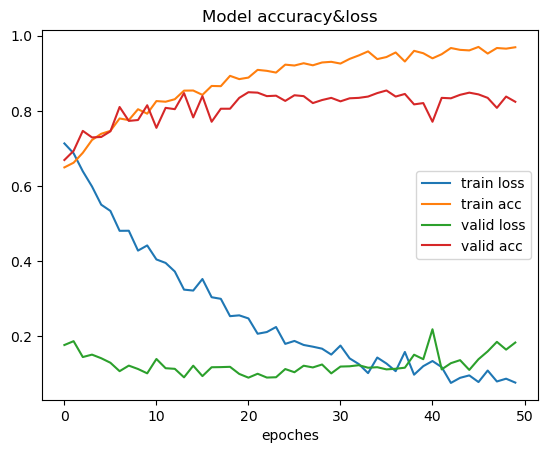

In [18]:
plt.plot(np.arange(len(train_losses)), train_losses,label="train loss")
plt.plot(np.arange(len(train_acces)), train_acces, label="train acc")
plt.plot(np.arange(len(eval_losses)), eval_losses, label="valid loss")
plt.plot(np.arange(len(eval_acces)), eval_acces, label="valid acc")
plt.legend() 
plt.xlabel('epoches')
plt.title('Model accuracy&loss')
plt.show()